## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/codes.txt'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/valid.txt'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/images'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/labels')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

IndexError: index 0 is out of bounds for axis 0 with size 0

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/images/0006R0_f02040.png'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/images/Seq05VD_f01050.png'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/images/0001TP_007410.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/labels/Seq05VD_f00000_P.png'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/labels/0016E5_05520_P.png'),
 PosixPath('/notebooks/course-v3/nbs/dl1/data/camvid/labels/0016E5_00540_P.png')]

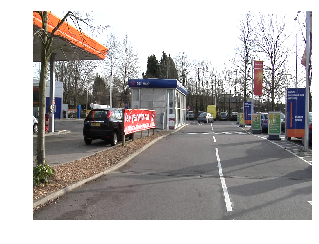

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

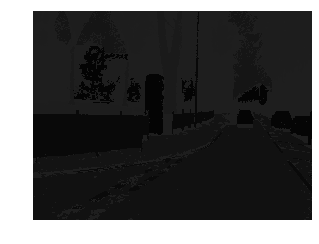

In [25]:
img_l = lbl_names[0]
img_l = open_image(img_l)
img_l.show(figsize=(5,5), alpha=1)

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

torch.Size([1, 720, 960])


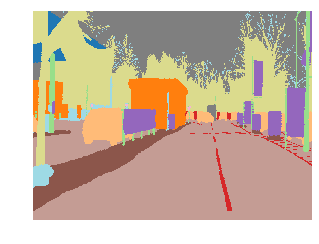

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
print(mask.shape)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 12, 12, 12],
          [26, 26, 26,  ..., 12, 12, 12],
          [26, 26, 26,  ..., 12, 12, 12],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [15]:
size = src_size//2
bs=4  #8 (CUDA out of memory for 8)

In [16]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

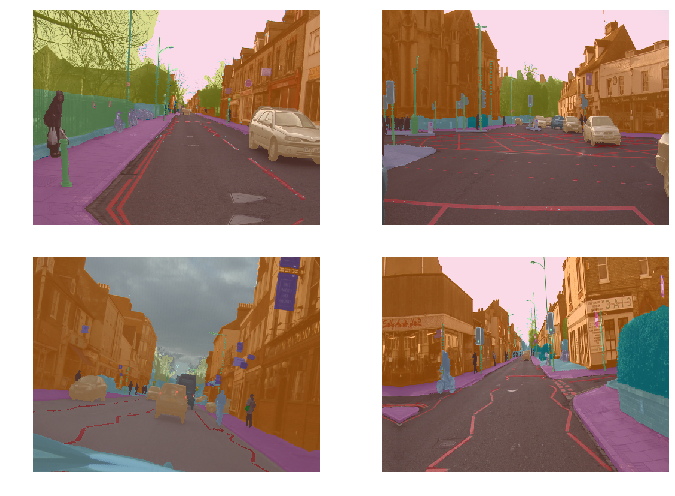

In [18]:
data.show_batch(2, figsize=(10,7))

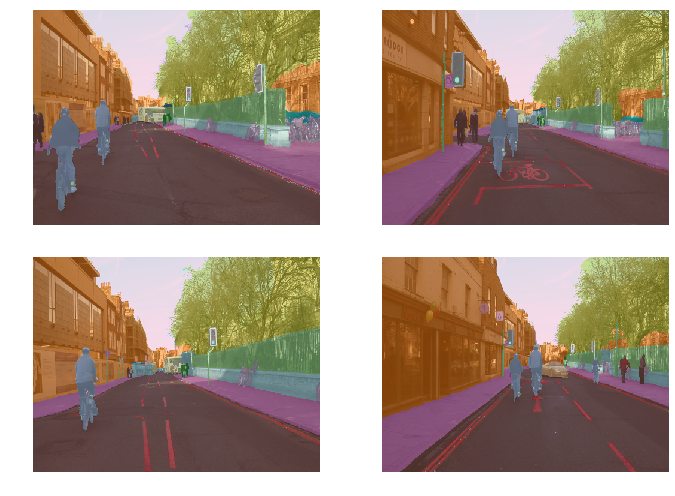

In [36]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


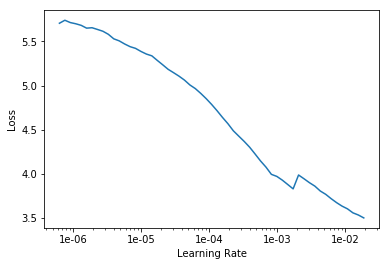

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=3e-3

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.007837,0.906481,0.777404
2,0.745094,0.613785,0.846059
3,0.677771,0.646452,0.835799
4,0.619955,0.538954,0.848037
5,0.603284,0.462265,0.877266
6,0.594745,0.472949,0.862471
7,0.569045,0.467486,0.881817
8,0.523848,0.472896,0.867741
9,0.516611,0.419085,0.879494
10,0.420973,0.322982,0.908504


In [26]:
learn.save('camvid-stage-1')

In [27]:
learn.load('camvid-stage-1');

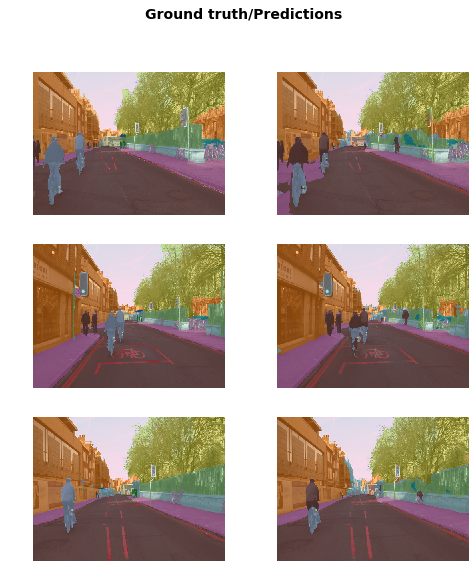

In [28]:
learn.show_results(rows=3, figsize=(8,9))

In [29]:
learn.unfreeze()

In [30]:
lrs = slice(lr/400,lr/4)

In [31]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.375116,0.320182,0.909232
2,0.364318,0.318683,0.909323
3,0.353223,0.320144,0.907710
4,0.349798,0.318939,0.909816
5,0.340920,0.323574,0.908869
6,0.348349,0.322103,0.911397
7,0.330661,0.299293,0.919060
8,0.328679,0.335656,0.906789
9,0.322695,0.297144,0.919314
10,0.315357,0.323795,0.915093


In [32]:
learn.save('camvid-stage-2-92');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=3

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


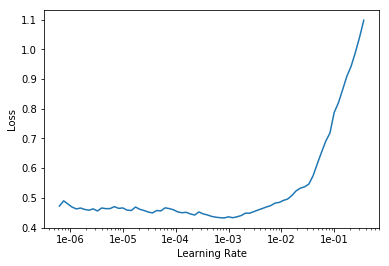

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

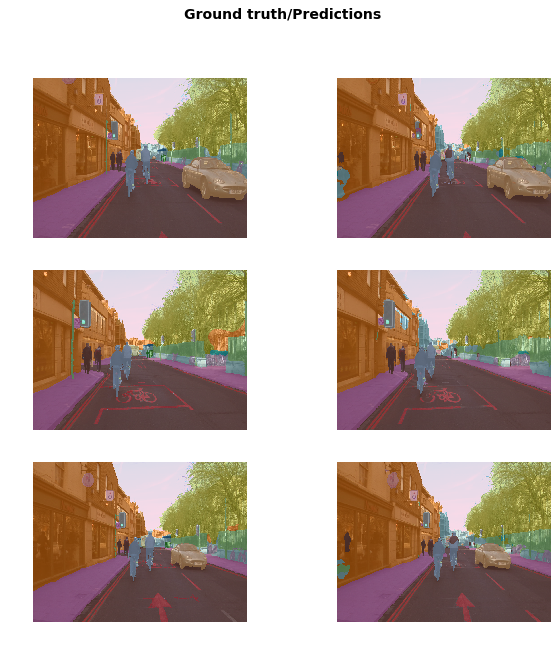

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin